<a href="https://colab.research.google.com/github/brittanyasare04/lab_scraping/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

With the data in and wrangled, we can now do some analysis:

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

In [5]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/ppa?purveyor=owner#search=2~gallery~80' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

In [6]:
# Parsing the data
from bs4 import BeautifulSoup as soup
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

In [7]:
import re #importing regular expressions

types =  ['vacuum', 'juicer','cooler','refridgerator','distiller','sewing machine','processor','grinder','sifter','microwave',
          'cooker','slicer','stove','air conditioner','toaster','pump','hose','machine','freezer',
          'dispenser','oven','maker','blender', 'warmer']

data = []
for k in range (len(listings)):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # getting type from the title string
    words = title.split()
    hits = [word for word in words if word in types]
    if len(hits) == 0:
        type = 'missing'
    else:
        type = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    data.append({'title':title,'price':price,'year':year,'link':link,'type':type})

In [8]:
import os

#wrangling the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)

#create dictioinary ig it does not exist
output_dir = './src'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv('./src/craigslist_cville_instruments.csv')
df.head()

(107, 6)


,title,price,year,link,type,age
0,little chief smoker includes woodchips,50,NaN,https://charlottesville.craigslist.org/app/d/e...,missing,NaN
1,iceman countertop icemaker,30,NaN,https://charlottesville.craigslist.org/app/d/e...,missing,NaN
2,kenmore 10 sewing machine with foot pedal,40,NaN,https://charlottesville.craigslist.org/app/d/e...,machine,NaN
3,hamilton beach large slow cooker /crock pot,20,NaN,https://charlottesville.craigslist.org/app/d/e...,cooker,NaN
4,5000 btu ge room air conditioner a/c,85,NaN,https://charlottesville.craigslist.org/app/d/e...,missing,NaN


count     107.000000
mean      323.981308
std       552.945457
min        10.000000
25%        45.000000
50%       125.000000
75%       437.500000
max      4000.000000
Name: price, dtype: float64


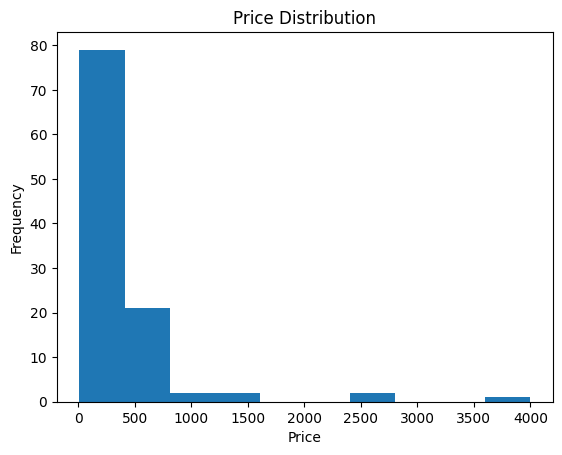

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64


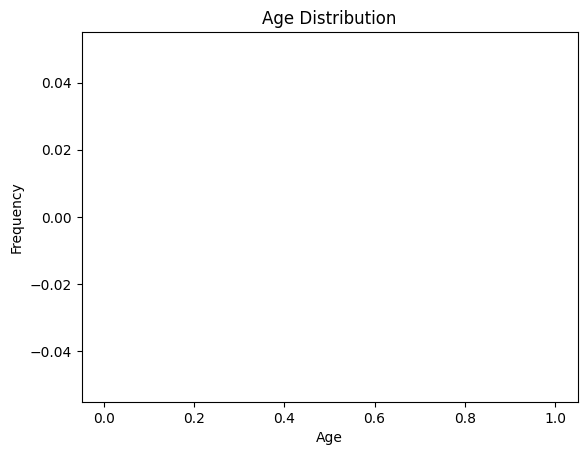

In [9]:
#analysis of the data
print(df['price'].describe())
df['price'].hist(grid=False)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Based on the data we scraped, there seemingly is an interesting relationship between the price of an appliance and the frequency it was bought at. Telling from the data, we can see that appliances that are below $1500 are purchased at a higher frequency than that of the appliances that are priced higher.

In [11]:
# Price by type
df.loc[:,['price','type']].groupby('type').describe()

price                                                           \
          count         mean          std    min     25%    50%      75%   
type                                                                       
blender     1.0   175.000000          NaN  175.0  175.00  175.0   175.00   
cooker      3.0    28.333333    10.408330   20.0   22.50   25.0    32.50   
cooler      1.0   500.000000          NaN  500.0  500.00  500.0   500.00   
dispenser   1.0    80.000000          NaN   80.0   80.00   80.0    80.00   
freezer     4.0  1362.500000  1798.784312  100.0  287.50  675.0  1750.00   
hose        1.0    25.000000          NaN   25.0   25.00   25.0    25.00   
juicer      2.0    25.000000     0.000000   25.0   25.00   25.0    25.00   
machine     5.0   422.000000   380.157862   40.0  120.00  450.0   500.00   
maker       8.0   197.750000   255.379130   10.0   25.75   75.0   268.75   
microwave   5.0    80.000000    33.354160   40.0   60.00   75.0   100.00   
missing    56.0   333.285714   500.165090   10.0   57.50  150.0   412.50   
oven        4.0   253.750000   234.995567  100.0  111.25  157.5   300.00   
processor   1.0    40.000000          NaN   40.0   40.00   40.0    40.00   
pump        6.0   330.833333   299.423056   35.0   81.25  300.0   481.25   
slicer      1.0    20.000000          NaN   20.0   20.00   20.0    20.00   
stove       2.0   775.000000   883.883476  150.0  462.50  775.0  1087.50   
toaster     3.0    36.666667    11.547005   30.0   30.00   30.0    40.00   
vacuum      2.0    87.500000    88.388348   25.0   56.25   87.5   118.75   
warmer      1.0   650.000000          NaN  650.0  650.00  650.0   650.00   

                   
              max  
type               
blender     175.0  
cooker       40.0  
cooler      500.0  
dispenser    80.0  
freezer    4000.0  
hose         25.0  
juicer       25.0  
machine    1000.0  
maker       650.0  
microwave   125.0  
missing    2500.0  
oven        600.0  
processor    40.0  
pump        800.0  
slicer       20.0  
stove      1400.0  
toaster      50.0  
vacuum      150.0  
warmer      650.0

Looking here at the data based on th appliances, we can see that the most expensive item that is typically sold on craiglist are freezers and the average cheapest appliance are slicers. The missing catergorization of appliances makes up the bulk of listings with maker being the second most frequent with its total count of eight. Blender, cooler, dispenser, processor, warmer, slicer, and hose make up the least amount of items sold category wise.

In [12]:
# Age by type
df.loc[:,['age','type']].groupby('type').describe()

age                             
          count mean std min 25% 50% 75% max
type                                        
blender     0.0  NaN NaN NaN NaN NaN NaN NaN
cooker      0.0  NaN NaN NaN NaN NaN NaN NaN
cooler      0.0  NaN NaN NaN NaN NaN NaN NaN
dispenser   0.0  NaN NaN NaN NaN NaN NaN NaN
freezer     0.0  NaN NaN NaN NaN NaN NaN NaN
hose        0.0  NaN NaN NaN NaN NaN NaN NaN
juicer      0.0  NaN NaN NaN NaN NaN NaN NaN
machine     0.0  NaN NaN NaN NaN NaN NaN NaN
maker       0.0  NaN NaN NaN NaN NaN NaN NaN
microwave   0.0  NaN NaN NaN NaN NaN NaN NaN
missing     0.0  NaN NaN NaN NaN NaN NaN NaN
oven        0.0  NaN NaN NaN NaN NaN NaN NaN
processor   0.0  NaN NaN NaN NaN NaN NaN NaN
pump        0.0  NaN NaN NaN NaN NaN NaN NaN
slicer      0.0  NaN NaN NaN NaN NaN NaN NaN
stove       0.0  NaN NaN NaN NaN NaN NaN NaN
toaster     0.0  NaN NaN NaN NaN NaN NaN NaN
vacuum      0.0  NaN NaN NaN NaN NaN NaN NaN
warmer      0.0  NaN NaN NaN NaN NaN NaN NaN

Due to the insufficent data of the age of the appliances, we cannot group the appliances by age and type.

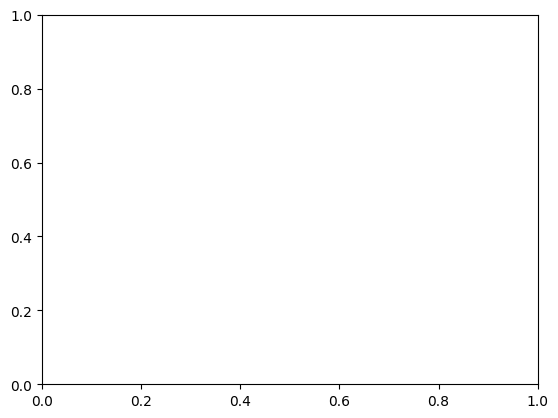

In [14]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='type')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # Removed as there's no legend without data points

Due again to the lack of data in the age of the appliance, creating a scatterplot based on that and price render difficult due to the inability to compare the missing data.

           log_price  log_age
log_price   1.837996      NaN
log_age          NaN      NaN
           log_price  log_age
log_price        1.0      NaN
log_age          NaN      NaN


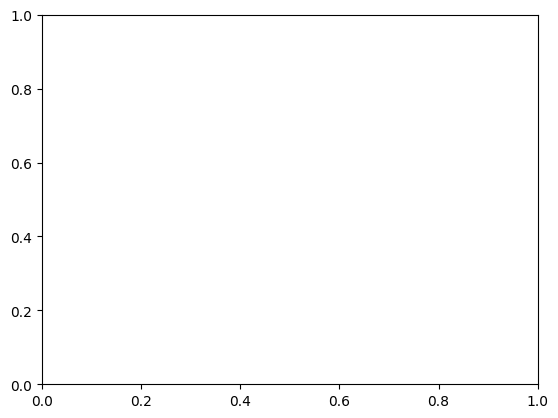

In [16]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='type')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

Based on the data scraped, it was clear that the age category of the appliances had many missing values, this meant that the year that the appliance was would often be a data point that was left out of the listing. This made it difficult to visualize the data about the age of the products.

In [17]:
!git config --global user.name "brittanyasare04"
!git config --global user.email "brittanyasare04@gmail.com"

In [18]:
!git status
!ls -la
!git add <assignment.ipynb>
!git commit -m "Brittany Asare - Lab 1"
!git push origin main

fatal: not a git repository (or any of the parent directories): .git
total 20
drwxr-xr-x 1 root root 4096 Sep 15 19:26 .
drwxr-xr-x 1 root root 4096 Sep 15 19:23 ..
drwxr-xr-x 4 root root 4096 Sep  9 13:46 .config
drwxr-xr-x 1 root root 4096 Sep  9 13:46 sample_data
drwxr-xr-x 2 root root 4096 Sep 15 19:26 src
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `git add <assignment.ipynb>'
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
